# Name: Arvind Ganesh

In [10]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
batch_size = 64

transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
trainset = torchvision.datasets.MNIST('~/.pytorch/MNIST_data/', train = True, download = True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)

testset = torchvision.datasets.MNIST('~/.pytorch/MNIST_data/', train = False, download = True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True)

In [136]:
class learned_relu(nn.Module):
    def __init__(self, k0 = 1, k1 = 1):
        super().__init__()
        ones = torch.tensor([1.0])
        self.k0 = nn.Parameter(k0 * ones)
        self.k1 = nn.Parameter(k1 * ones)
        
    def forward(self, x):
        return self.k1 * x + self.k0

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.output = nn.Linear(784, 10)
        self.LReLU = learned_relu()
        
    def forward(self, x):
        x = self.output(x)
        x = self.LReLU(x)
        
        return x
    
model = Network()
model

Network(
  (output): Linear(in_features=784, out_features=10, bias=True)
  (LReLU): learned_relu()
)

In [137]:
print(model.LReLU.k0)
print(model.LReLU.k1)

Parameter containing:
tensor([1.], requires_grad=True)
Parameter containing:
tensor([1.], requires_grad=True)


In [138]:
from torch import optim
from sklearn.metrics import confusion_matrix
cm = np.zeros((10,10))

optimizer = optim.SGD(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()
epochs = 20
train_loss = []
test_loss = []
train_acc = []
test_acc = []
train_F1 = []
test_F1 = []
k0_val = []
k1_val = []
for e in range(1,epochs+1):
    print('Epoch:',e)
    running_loss = 0
    train_correct = 0
    cm = np.zeros((10,10))
    cm_diag = np.zeros(10)
    
    # Train model
    for images, labels in trainloader:
        input = images.resize_(images.shape[0],torch.numel(images[0]))

        # Train batch
        output = model(input)
        optimizer.zero_grad()
        loss = criterion(output, labels)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        # Confusion matrix
        predictions = torch.argmax(torch.nn.functional.softmax(output, dim=1), dim=1)
        cm_temp = confusion_matrix(labels, predictions,labels = [0,1,2,3,4,5,6,7,8,9])
        cm += cm_temp
        cm_diag += np.diag(cm_temp)
        
    # Training F1 score and accuracy computations for epoch
    train_correct += np.sum(cm_diag)
    recall = cm_diag / np.sum(cm, axis = 1)
    precision = cm_diag / np.sum(cm, axis = 0)
    mean_precision = np.mean(precision)
    mean_recall = np.mean(recall)
    train_F1_score = 2 * mean_precision * mean_recall / (mean_precision + mean_recall)
    train_accuracy = 100 * train_correct / len(trainset)
    print('Train accuracy: %lf, Train F1 score: %lf' %  (train_accuracy, train_F1_score) )
    
    # Store metrics
    train_loss.append(running_loss)
    train_acc.append(train_accuracy)
    train_F1.append(train_F1_score)
    
    # Store activation function parameters
    k0_val.append(model.LReLU.k0)
    k1_val.append(model.LReLU.k1)
    
    # Set model to evaluation mode before testing
    with torch.no_grad():
        model.eval()
        running_loss = 0
        test_correct = 0
        cm = np.zeros((10,10))
        cm_diag = np.zeros(10)
        
        # Test model
        for images, labels in testloader:
            input = images.resize_(images.shape[0],torch.numel(images[0]))
            
            # Test batch
            output = model(input)
            loss = criterion(output, labels)
            running_loss += loss.item()
            
            # Confusion matrix
            predictions = torch.argmax(torch.nn.functional.softmax(output, dim=1), dim=1)
            cm_temp = confusion_matrix(labels, predictions,labels = [0,1,2,3,4,5,6,7,8,9])
            cm += cm_temp
            cm_diag += np.diag(cm_temp)
        
        # Test F1 score and accuracy computations for epoch
        test_correct += np.sum(cm_diag)
        recall = cm_diag / np.sum(cm, axis = 1)
        precision = cm_diag / np.sum(cm, axis = 0)
        mean_precision = np.mean(precision)
        mean_recall = np.mean(recall)
        test_F1_score = 2 * mean_precision * mean_recall / (mean_precision + mean_recall)
        test_accuracy = 100 * test_correct / len(testset)
        print('Test accuracy: %lf, Test F1 score: %lf' %  (test_accuracy, test_F1_score) )

    # Store metrics
    test_loss.append(running_loss)
    test_acc.append(test_accuracy)
    test_F1.append(test_F1_score)
    
#    test_accuracy = 100 * test_correct / len(testset)
#    print("Test accuracy: %lf %lf, Test F1 score: %lf"%(test_accuracy, test_f1_score))

Epoch: 1
Train accuracy: 57.690000, Train F1 score: 0.588859
Test accuracy: 78.030000, Test F1 score: 0.783917
Epoch: 2
Train accuracy: 80.506667, Train F1 score: 0.805409
Test accuracy: 83.790000, Test F1 score: 0.836836
Epoch: 3
Train accuracy: 84.005000, Train F1 score: 0.838680
Test accuracy: 86.200000, Test F1 score: 0.860345
Epoch: 4
Train accuracy: 85.743333, Train F1 score: 0.855837
Test accuracy: 87.470000, Test F1 score: 0.873178
Epoch: 5
Train accuracy: 86.795000, Train F1 score: 0.866323
Test accuracy: 88.140000, Test F1 score: 0.879984
Epoch: 6
Train accuracy: 87.583333, Train F1 score: 0.874264
Test accuracy: 88.680000, Test F1 score: 0.885396
Epoch: 7
Train accuracy: 88.151667, Train F1 score: 0.879965
Test accuracy: 89.210000, Test F1 score: 0.890778
Epoch: 8
Train accuracy: 88.601667, Train F1 score: 0.884493
Test accuracy: 89.580000, Test F1 score: 0.894414
Epoch: 9
Train accuracy: 88.925000, Train F1 score: 0.887781
Test accuracy: 89.910000, Test F1 score: 0.897775
E

In [139]:
import matplotlib.pyplot as plt
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "black",
    "axes.facecolor": "white",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "black",
    "figure.edgecolor": "black",
    "savefig.facecolor": "black",
    "savefig.edgecolor": "black"})


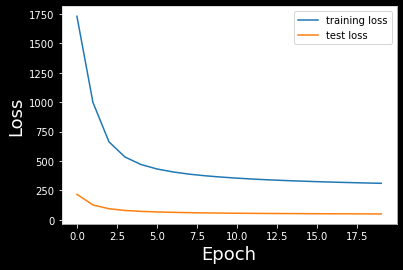

Text(0, 0.5, 'k1 parameter')

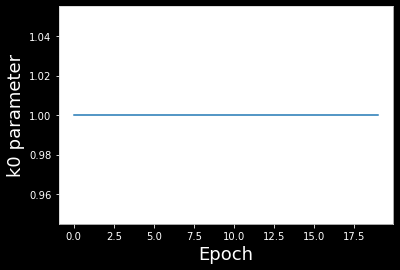

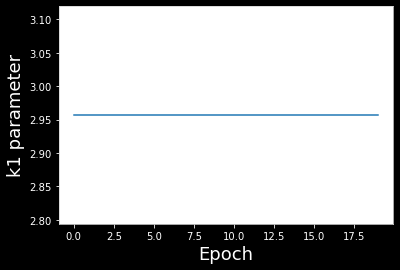

In [140]:
plt.plot(train_loss, label = 'training loss')
plt.plot(test_loss, label = 'test loss')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend()
plt.show()

plt.figure()
plt.plot(k0_val)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('k0 parameter', fontsize=18)
plt.figure()
plt.plot(k1_val)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('k1 parameter', fontsize=18)